In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean

%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

## Import NPGO Index file

In [4]:
df = pd.read_csv('/ocean/ksuchy/MOAD/observe/NPGO.csv', index_col=0,header=0)

In [5]:
df.index.name = "YEAR"
df = df.apply(pd.to_numeric) # convert all columns of DataFrame
#df = df[:-1]

### Select years 2007 to 2022 for SOPO report

In [6]:
df.loc[2007:2023]

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
YEAR,,,,,,,,,,,,
2007,-0.243309,-0.729927,-0.182149,0.384615,0.144928,1.230000,1.230000,1.430000,0.110011,1.270000,0.137363,0.218341
2008,0.179856,1.140000,1.370000,1.400000,1.740000,1.280000,1.430000,2.140000,2.230000,1.770000,1.970000,0.227273
2009,0.138313,0.110011,0.302115,0.240385,0.180180,0.270270,0.178571,0.139276,0.102669,1.150000,1.050000,1.060000
2010,2.060000,1.840000,1.650000,1.180000,1.870000,1.240000,1.150000,1.080000,1.000000,1.610000,0.101215,0.128370
2011,0.310559,0.181818,1.200000,0.167785,1.390000,1.110000,1.040000,1.040000,1.330000,1.200000,0.267380,0.757576
2012,0.119904,0.115875,1.120000,1.930000,1.630000,1.940000,1.860000,1.730000,1.360000,1.870000,1.400000,1.200000
2013,1.230000,1.200000,0.155521,0.210084,0.117371,0.137552,0.221729,0.195312,0.256410,-0.680272,-0.124224,-1.450000
2014,-0.256410,-0.374532,-0.220264,-0.161812,0.440529,-0.239808,-0.746269,-0.183486,-0.128700,0.235849,0.320513,-0.280899
2015,-0.181488,-1.270000,-1.400000,-1.380000,-0.138889,-1.250000,-1.470000,-1.930000,-2.100000,-1.310000,-2.250000,-1.110000


In [7]:
NPGO = df.loc[2007:2023].to_numpy().flatten()

## Import Central SoG Diatom Anomalies file

In [8]:
df2 = pd.read_csv('/ocean/ksuchy/MOAD/observe/CentralSoG_DiatomAnomalies.csv', index_col=0)

In [9]:
df2.index.name = "YEAR"
df2 = df2.apply(pd.to_numeric) # convert all columns of DataFrame


In [10]:
df2

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
YEAR,,,,,,,,,,,,
2007,-0.051429,-0.115600,-5.629434,-2.115458,2.100580,3.436618,3.326997,-0.083708,1.322802,-0.512770,-0.269054,-0.162526
2008,-0.065813,-0.108095,-3.421642,6.067574,6.755398,6.482838,11.005395,5.699689,7.005173,0.705093,-0.028362,-0.043014
2009,-0.024802,0.009420,-3.627078,8.780571,-0.230984,2.039864,10.582235,6.657777,0.678862,0.706104,-0.043199,-0.057007
2010,-0.055858,-0.134747,-2.109467,0.954250,1.664310,3.376311,7.944076,11.272212,5.140868,1.005262,0.514134,0.139671
2011,0.092240,-0.087942,-6.051827,-24.107306,4.564972,5.166389,1.013101,-1.087454,1.311713,0.006898,0.143807,0.208702
2012,0.079925,-0.039747,-5.505043,-7.330854,4.687487,7.530653,-3.381940,-3.274194,-0.984710,-0.064473,-0.440919,-0.291376
2013,-0.147475,-0.069456,-2.006077,9.625019,0.576362,-0.701951,2.040490,2.089811,-1.421995,0.058990,0.301818,0.435811
2014,0.293074,0.944775,5.858756,2.844423,-7.150425,-6.894628,-6.281658,-4.137903,-1.739455,-0.715152,-0.505433,-0.332068
2015,-0.162905,0.065555,13.596614,0.331762,-3.171817,-0.401476,4.002137,1.913663,-0.871563,0.536748,0.652945,0.440732


In [11]:
Diatom_Anom=df2.to_numpy().flatten()

In [12]:
Diatom_Anom

array([-5.14286370e-02, -1.15600407e-01, -5.62943353e+00, -2.11545807e+00,
        2.10058006e+00,  3.43661831e+00,  3.32699700e+00, -8.37077780e-02,
        1.32280192e+00, -5.12770237e-01, -2.69054234e-01, -1.62525739e-01,
       -6.58125170e-02, -1.08094747e-01, -3.42164200e+00,  6.06757396e+00,
        6.75539774e+00,  6.48283771e+00,  1.10053954e+01,  5.69968904e+00,
        7.00517279e+00,  7.05093423e-01, -2.83624140e-02, -4.30136690e-02,
       -2.48024370e-02,  9.42000300e-03, -3.62707836e+00,  8.78057117e+00,
       -2.30983759e-01,  2.03986378e+00,  1.05822346e+01,  6.65777729e+00,
        6.78861904e-01,  7.06104233e-01, -4.31992540e-02, -5.70074890e-02,
       -5.58577070e-02, -1.34746727e-01, -2.10946663e+00,  9.54249806e-01,
        1.66430983e+00,  3.37631126e+00,  7.94407633e+00,  1.12722117e+01,
        5.14086842e+00,  1.00526196e+00,  5.14134276e-01,  1.39670571e-01,
        9.22397730e-02, -8.79419570e-02, -6.05182740e+00, -2.41073062e+01,
        4.56497218e+00,  

In [13]:
Diatom_Anom.max()

14.31589576

### Get date into proper format

In [14]:
date = []
for year in range(2007, 2023):
    for month in range(1, 13):
        index = df.index == str(year)
        date.append(datetime(year, month, 1))
        
        

date = np.array(date)
#NPGO = df.loc[2007:2020].to_numpy().flatten()
#Nitrate_Anom = df2.to_numpy().flatten()

In [15]:
date

array([datetime.datetime(2007, 1, 1, 0, 0),
       datetime.datetime(2007, 2, 1, 0, 0),
       datetime.datetime(2007, 3, 1, 0, 0),
       datetime.datetime(2007, 4, 1, 0, 0),
       datetime.datetime(2007, 5, 1, 0, 0),
       datetime.datetime(2007, 6, 1, 0, 0),
       datetime.datetime(2007, 7, 1, 0, 0),
       datetime.datetime(2007, 8, 1, 0, 0),
       datetime.datetime(2007, 9, 1, 0, 0),
       datetime.datetime(2007, 10, 1, 0, 0),
       datetime.datetime(2007, 11, 1, 0, 0),
       datetime.datetime(2007, 12, 1, 0, 0),
       datetime.datetime(2008, 1, 1, 0, 0),
       datetime.datetime(2008, 2, 1, 0, 0),
       datetime.datetime(2008, 3, 1, 0, 0),
       datetime.datetime(2008, 4, 1, 0, 0),
       datetime.datetime(2008, 5, 1, 0, 0),
       datetime.datetime(2008, 6, 1, 0, 0),
       datetime.datetime(2008, 7, 1, 0, 0),
       datetime.datetime(2008, 8, 1, 0, 0),
       datetime.datetime(2008, 9, 1, 0, 0),
       datetime.datetime(2008, 10, 1, 0, 0),
       datetime.datetime(200

## Plot NPGO Index vs. monthly Central SoG diatom anomalies

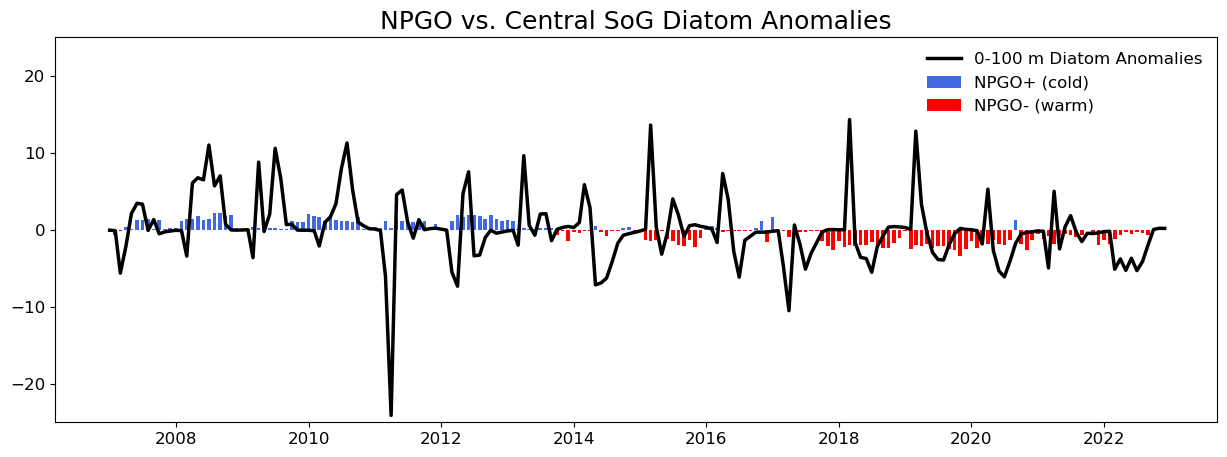

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))


ax.bar(date[NPGO>0], NPGO[NPGO>0], width=20, color='royalblue',label='NPGO+ (cold)')
ax.bar(date[NPGO<0], NPGO[NPGO<0], width=20, color='r',label='NPGO- (warm)')
ax.set_ylim(-25,25)
ax.plot(date,Diatom_Anom,color='k',linewidth=2.5,label='0-100 m Diatom Anomalies')
ax.set_title('NPGO vs. Central SoG Diatom Anomalies',fontsize=18)
ax.legend(frameon=False,loc=1)

In [17]:
Diatom_Anom_June=df2['Jun'] # to get June diatom anomalies

In [18]:
Diatom_Anom_June

YEAR
2007    3.436618
2008    6.482838
2009    2.039864
2010    3.376311
2011    5.166389
2012    7.530653
2013   -0.701951
2014   -6.894628
2015   -0.401476
2016   -2.820405
2017   -1.918606
2018   -3.737933
2019   -2.931932
2020   -5.341715
2021    0.413404
2022   -3.697429
Name: Jun, dtype: float64

In [19]:
## Annual NPGO values
NPGO_Annual=[0.416655983,1.406427404,0.410149171,1.242465357,0.832926488,1.356314911,0.122457003,-0.132940854,-1.315864758,-0.030001073,-0.570698404,\
             -1.901666667,-2.188857716,-1.558333333,-0.884166667,-0.606666667] 

In [20]:
NPGO_Annual

[0.416655983,
 1.406427404,
 0.410149171,
 1.242465357,
 0.832926488,
 1.356314911,
 0.122457003,
 -0.132940854,
 -1.315864758,
 -0.030001073,
 -0.570698404,
 -1.901666667,
 -2.188857716,
 -1.558333333,
 -0.884166667,
 -0.606666667]

## Plot Annual NPGO Index vs. June Diatom Anomalies

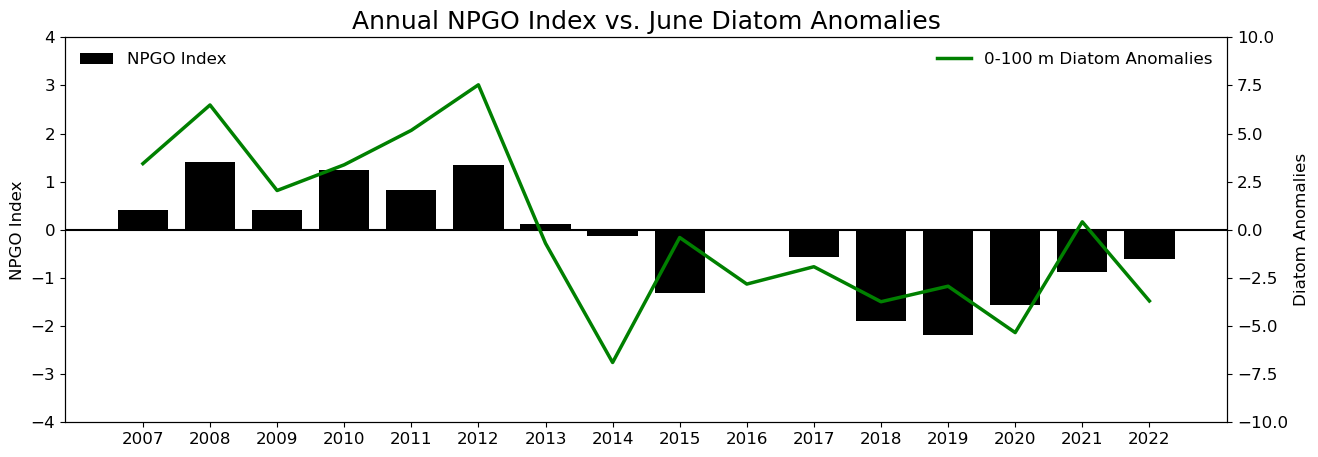

In [21]:
fig, ax1 = plt.subplots(figsize=(15, 5))
x=['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']

ax2 = ax1.twinx()
ax1.bar(x, NPGO_Annual, width=.75, color='k',label='NPGO Index')
#ax.bar(df3.index['NPGO_May_Anomalies'<0], df3['NPGO_May_Anomalies'<0], width=20, color='r',label='NPGO- (warm)')
ax1.set_ylim(-4,4)
ax2.plot(x,Diatom_Anom_June,color='green',linewidth=2.5,label='0-100 m Diatom Anomalies')
ax2.set_ylim(-10,10)
ax1.set_ylabel('NPGO Index')
ax2.set_ylabel('Diatom Anomalies')
ax1.axhline(y=0,color='k')
ax1.set_title('Annual NPGO Index vs. June Diatom Anomalies',fontsize=18)
ax1.legend(frameon=False,loc=2)
ax2.legend(frameon=False,loc=1)

## Now plot full NPGO Index vs. June diatom anomalies

Text(0, 0.5, 'Diatom Anomalies (mmol N m$^{-2}$)')

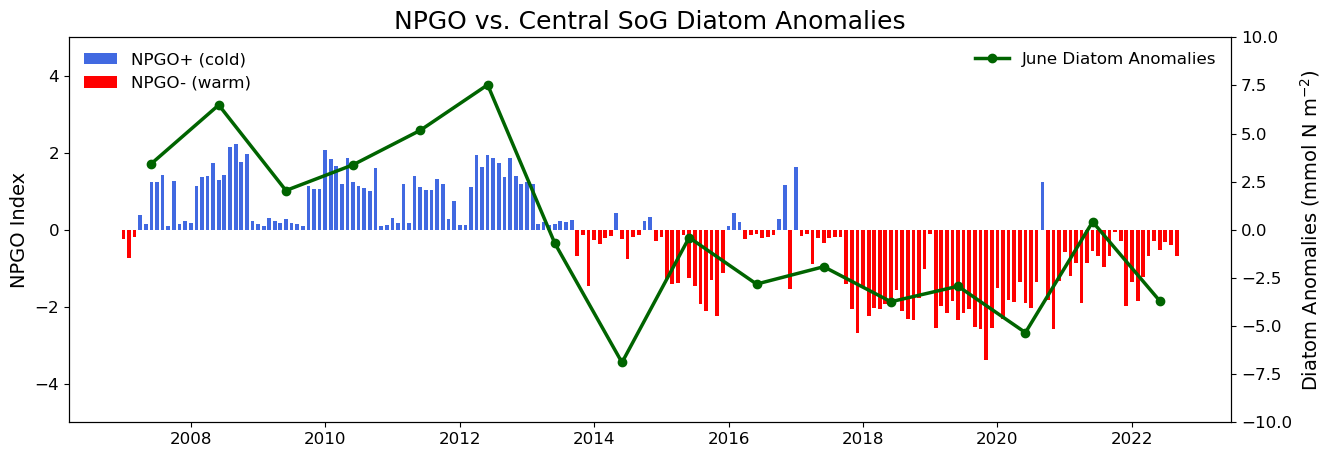

In [22]:
fig, ax1 = plt.subplots(figsize=(15, 5))
x2=[date[5],date[17],date[29],date[41],date[53],date[65],date[77],date[89],date[101],date[113],date[125],date[137],date[149],date[161],date[173],date[185]]
ax2 = ax1.twinx()
ax1.bar(date[NPGO>0], NPGO[NPGO>0], width=20, color='royalblue',label='NPGO+ (cold)')
ax1.bar(date[NPGO<0], NPGO[NPGO<0], width=20, color='r',label='NPGO- (warm)')
ax1.set_ylim(-5,5)
ax2.set_ylim(-10,10)
ax2.plot(x2,Diatom_Anom_June,marker='o',color='darkgreen',linewidth=2.5,label='June Diatom Anomalies')
ax1.set_title('NPGO vs. Central SoG Diatom Anomalies',fontsize=18)
ax1.legend(frameon=False,loc=2)
ax2.legend(frameon=False,loc=1)
ax1.set_ylabel('NPGO Index',fontsize=14)
ax2.set_ylabel('Diatom Anomalies (mmol N m$^{-2}$)',fontsize=14)

## Now plot full NPGO Index vs. July diatom anomalies

In [23]:
Diatom_Anom_Jul=df2['Jul'] # to grab July diatom anomalies only

Text(0, 0.5, 'Diatom Anomalies (mmol N m$^{-2}$)')

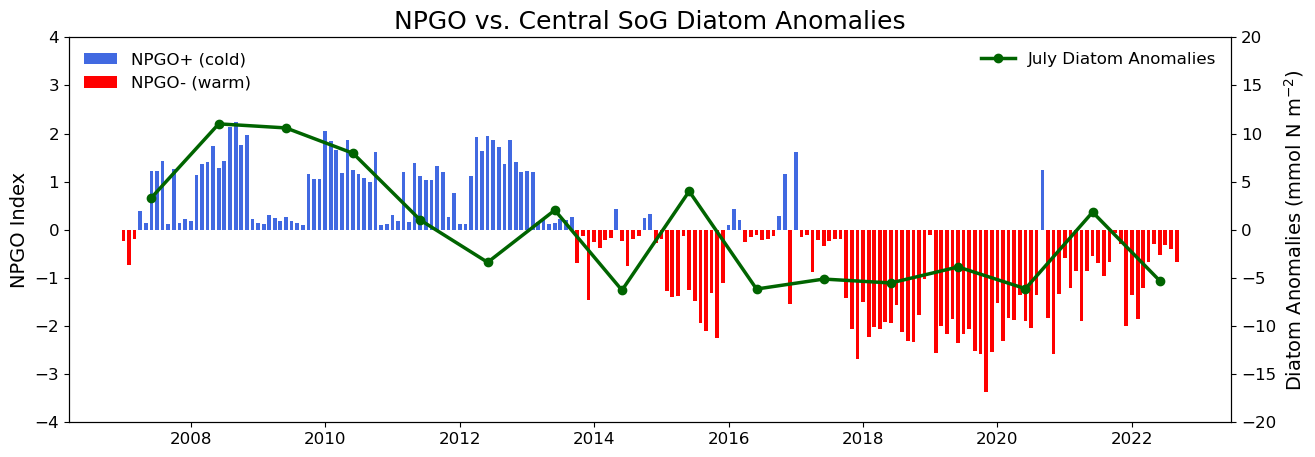

In [24]:
fig, ax1 = plt.subplots(figsize=(15, 5))
x2=[date[5],date[17],date[29],date[41],date[53],date[65],date[77],date[89],date[101],date[113],date[125],date[137],date[149],date[161],date[173],date[185]]
ax2 = ax1.twinx()
ax1.bar(date[NPGO>0], NPGO[NPGO>0], width=20, color='royalblue',label='NPGO+ (cold)')
ax1.bar(date[NPGO<0], NPGO[NPGO<0], width=20, color='r',label='NPGO- (warm)')
ax1.set_ylim(-4,4)
ax2.set_ylim(-20,20)
ax2.plot(x2,Diatom_Anom_Jul,marker='o',color='darkgreen',linewidth=2.5,label='July Diatom Anomalies')
ax1.set_title('NPGO vs. Central SoG Diatom Anomalies',fontsize=18)
ax1.legend(frameon=False,loc=2)
ax2.legend(frameon=False,loc=1)
ax1.set_ylabel('NPGO Index',fontsize=14)
ax2.set_ylabel('Diatom Anomalies (mmol N m$^{-2}$)',fontsize=14)